In [147]:

import matplotlib.pyplot as plt
from collections import Counter

def roll_dice(sides: int) -> int:
    """Roll a die with a specified number of sides."""
    return random.randint(1, sides)

def calculate_damage(damage_formula: str, crit: bool = False, extra_crit_damage: str = "", advantage: bool = False) -> int:
    """Calculate the damage based on a dice formula. Handle crits and advantage correctly."""
    components = damage_formula.split('+')
    total_damage = 0
    
    for component in components:
        if 'd' in component:
            num_dice, dice_sides = map(int, component.split('d'))
            # Double the number of dice for crits
            if crit:
                num_dice *= 2
            total_damage += sum(roll_dice(dice_sides) for _ in range(num_dice))
        else:
            total_damage += int(component)
    
    # Add the extra crit damage if it's a crit and a valid extra crit formula is provided
    if crit and extra_crit_damage:
        total_damage += calculate_damage(extra_crit_damage)
    
    return total_damage


def attack(attack_modifier: int, enemy_ac: int, crit_range: int = 20, advantage: bool = False) -> str:
    """Determine the outcome of an attack (hit, miss, or crit). Handle crit range and advantage."""
    roll = roll_dice(20)
    if advantage:
        roll = max(roll, roll_dice(20))
    
    if roll >= crit_range:
        return "crit"
    elif roll == 1:
        return "miss"
    elif roll + attack_modifier >= enemy_ac:
        return "hit"
    else:
        return "miss"

def combat_round(attacks: List[str], attack_modifier: int, 
                 crit_damage: str, miss_damage: str, enemy_ac: int, enemy_hp: int, 
                 crit_range: int = 20, advantage: bool = False, static_dpr: int = 0) -> (int, int):
    """
    Simulate a single round of combat and return the remaining hit points of the enemy and the damage dealt in that round.
    """
    total_damage_this_round = 0
    for i in range(len(attacks)):
        attack_result = attack(attack_modifier, enemy_ac, crit_range, advantage)
        if attack_result == "hit":
            damage = calculate_damage(attacks[i])
        elif attack_result == "crit":
            damage = calculate_damage(attacks[i], crit=True, extra_crit_damage=crit_damage)
        else:
            damage = calculate_damage(miss_damage)
        
        total_damage_this_round += damage
        enemy_hp -= damage
    enemy_hp -= static_dpr
    total_damage_this_round += static_dpr
    return enemy_hp, total_damage_this_round

def simulate_combat(num_simulations: int, attacks: List[str], attack_modifier: int, 
                    crit_damage: str, miss_damage: str, 
                    enemy_ac: int, initial_enemy_hp: int, 
                    crit_range: int = 20, advantage: bool = False, static_dpr: int = 0) -> List[tuple]:
    """
    Simulate the combat scenario a given number of times and return a list of tuples where:
    - First element is the average DPR for that combat
    - Second element is the number of rounds taken to defeat the enemy in that simulation.
    """
    results = []
    for _ in range(num_simulations):
        rounds_taken = 0
        total_damage = 0
        enemy_hp = initial_enemy_hp
        while enemy_hp > 0:
            rounds_taken += 1
            enemy_hp, damage_this_round = combat_round(attacks, attack_modifier, crit_damage, miss_damage, enemy_ac, enemy_hp, crit_range, advantage, static_dpr)
            total_damage += damage_this_round
        average_dpr = total_damage / rounds_taken
        results.append((average_dpr, rounds_taken))
    return results


def plot_histogram(results: List[int], title: str = "Rounds to Defeat Enemy"):
    """Plot a histogram of the simulate_combat results."""
    plt.hist(results, bins=range(1, max(results) + 2), align='left', rwidth=0.8, color='blue', edgecolor='black')
    plt.xlabel('Number of Rounds')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.grid(axis='y')
    plt.xticks(range(1, max(results) + 1))
    plt.show()


def generate_table(results: List[int]) -> dict:
    """Generate a table showing the frequency of each number of rounds in the results."""
    table = Counter(results)
    return dict(sorted(table.items()))

def print_markdown_table(table: dict):
    """Print the table in Markdown format."""
    # Table header
    print("| Number of Rounds | Frequency |")
    print("|------------------|-----------|")
    
    # Table rows
    for rounds, freq in table.items():
        print(f"| {rounds} | {freq} |")

In [148]:
num_sims=100000
combat1=simulate_combat(num_sims, ["2d6+4", "2d6+4"], 8, "0", "0", 16, 75, 20, True)
dpr1=list(zip(*combat1))[0]
rounds1=list(zip(*combat1))[1]
print("Average Rounds: ", sum(rounds1)/num_sims)
print("Average DPR: ", sum(dpr1)/num_sims)
print("Prob <3 Rounds: ", success_fraction(rounds, 4))

Average Rounds:  4.16366
Average DPR:  21.19532436507916
Prob <3 Rounds:  0.2985


In [149]:
combat2=simulate_combat(num_sims, ["2d6+4", "2d6+4"], 8, "1d12", "0", 16, 75, 20, True)
dpr2=list(zip(*combat2))[0]
rounds2=list(zip(*combat2))[1]
print("Average Rounds: ", sum(rounds2)/num_sims)
print("Average DPR: ", sum(dpr2)/num_sims)
print("Prob <3 Rounds: ", success_fraction(rounds2, 4))

Average Rounds:  3.97985
Average DPR:  22.778477023809646
Prob <3 Rounds:  0.26637


In [150]:
combat3=simulate_combat(num_sims, ["2d6+4", "2d6+4"], 8, "0", "0", 16, 75, 20, True, 1)
dpr3=list(zip(*combat3))[0]
rounds3=list(zip(*combat3))[1]
print("Average Rounds: ", sum(rounds3)/num_sims)
print("Average DPR: ", sum(dpr3)/num_sims)
print("Prob <3 Rounds: ", success_fraction(rounds3, 4))

Average Rounds:  3.98975
Average DPR:  22.18752248809505
Prob <3 Rounds:  0.21855


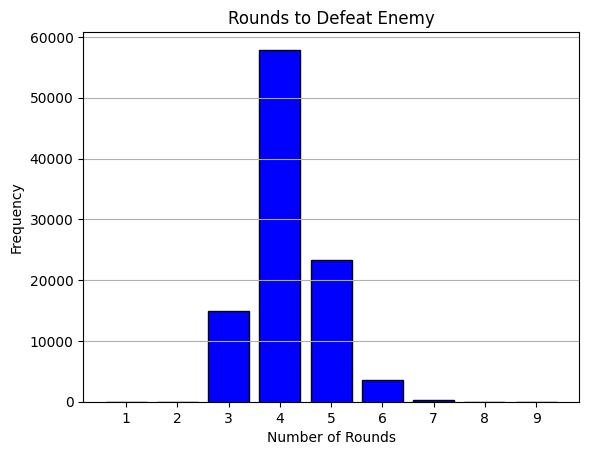

In [151]:
plot_histogram(rounds1)

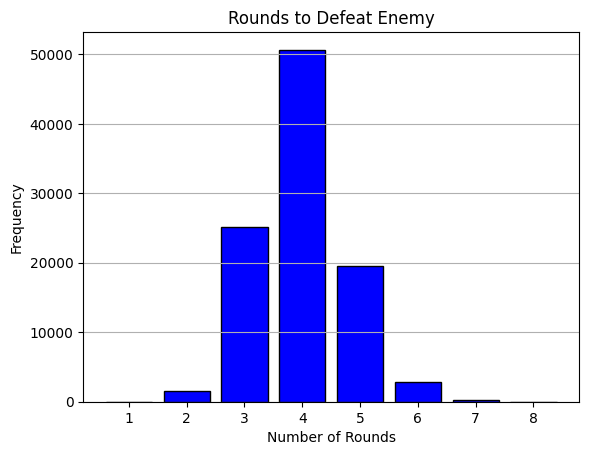

In [152]:
plot_histogram(rounds2)

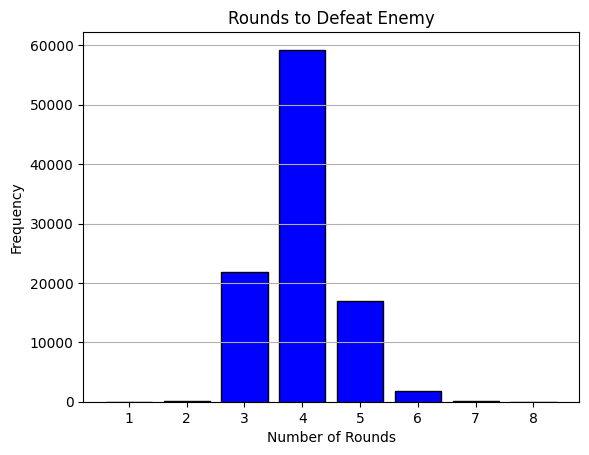

In [154]:
plot_histogram(rounds3)

In [133]:
print_markdown_table(generate_table(rounds1))

| Number of Rounds | Frequency |
|------------------|-----------|
| 2 | 31 |
| 3 | 14611 |
| 4 | 58025 |
| 5 | 23580 |
| 6 | 3420 |
| 7 | 313 |
| 8 | 20 |


In [134]:
print_markdown_table(generate_table(rounds2))

| Number of Rounds | Frequency |
|------------------|-----------|
| 2 | 1526 |
| 3 | 25122 |
| 4 | 50473 |
| 5 | 19649 |
| 6 | 2933 |
| 7 | 281 |
| 8 | 15 |
| 9 | 1 |


In [104]:
print_markdown_table(generate_table(combat3))

| Number of Rounds | Frequency |
|------------------|-----------|
| 4 | 2792 |
| 5 | 7192 |
| 6 | 16 |


In [ ]:
num_sims=10000
combat1=simulate_combat(num_sims, ["2d6+5", "2d6+5"], 9, "0", "0", 16, 150, )
print("Average Rounds: ", sum(combat1)/num_sims)
print("Prob <3 Rounds: ", success_fraction(combat1, 4))